<a href="https://colab.research.google.com/github/ketanhdoshi/ml/blob/master/lib/optimiser_lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimisation Functions
Notebooks - , 

**Todos**
* Cleanup HyperParam and GetOptimiser interface
* Comments for HyperParam
* Get rid of run_mnist from here 

**Done**
1. DONE HyperParam takes lr_sched flag for one cycle, lr find etc
2. DONE Implement LR Range Callback






### Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#export

from functools import partial
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim

In [ ]:
import IPython.core.debugger as db

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#export
from nb_util import accuracy, listify, compose
from nb_training import Callback, CancelFitException, MetricsCB

In [ ]:
from nb_arch import run_cnn_mnist, CNNArch
from nb_training import CudaCB

### HyperParameter Tracking

#### Get Optimiser

In [ ]:
#export

# ----------------------------
# Splitter function used to split the params of a model into sequential parameter groups
# based on a list of 'param_idxs'.
# eg. [3] produces two parameter groups viz. first is arch_params[:3] and second is arch_params[3:]
# eg. [3, 5] produces three parameter groups viz arch_params[:3], arch_params[3:5], arch_params[5:]
# ----------------------------
def split_sequence (arch, param_idxs):
  # arch.parameters() is a generator. Materialise it into a list
  params_all = list(arch.parameters())

  # Split the full parameter list into a list of sub-lists based on the parameter
  # indices. Each sub-list corresponds to a parameter group
  params_split = [params_all[i:j] for i, j in zip([0]+param_idxs, param_idxs+[None])]

  return (params_split)

# ----------------------------
# Create an Optimiser by preparing the arguments in the required format.
#
# 'arch' and 'opt_func' are always required. Either 'opt_groups' or 'lr' is required.
# If 'opt_groups' is provided, 'lr' is ignored
# If 'lr' is provided, 'opt_groups' is ignored
# 
# See the comments for the Optimiser class further down for more details about the
# format. We test this function below with some dummy arguments - see that for
# an example of the argument format
# ----------------------------
def get_optimiser (arch, lr, opt_func, opt_groups):
  if (opt_groups is not None):
    # Unpack the elements of the tuple
    split_func, hypers_group, hypers_common = opt_groups

    # Get the split parameter groups using the split function
    params_split = split_func(arch) if split_func is not None else arch.parameters()

    # Create a list of dictionaries. Each dictionary has the format:
    #   {'params': [parameters in parameter group], 'hypers_group_1': 'value', ...}
    # So in each dictionary, we merge one key for the 'params' with all the keys for
    # the hypers_group
    param_groups = [{'params': ps, **hg} for ps, hg in zip(params_split, hypers_group)]

    # Create the optimiser using the param groups and the 
    opt = opt_func(param_groups, **hypers_common)
  else:
    # This is the simple case where all parameters are in a single group and there
    # is only hyperparameter for the learning rate
    opt = opt_func(arch.parameters(), lr=lr)

  return (opt)

In [ ]:
# Test the optimiser is able to process the arguments correctly
def opt_func_test(pg, **hd): print(pg, hd)
# arch_dummy provides a arch_dummy.parameters() function that returns a list of parameters
def arch_dummy(): return (0)
arch_dummy.parameters = lambda : ['a', 'b', 'c', 'd', 'e']
arch_dummy.parameters()
test_split_func = partial(split_sequence, param_idxs=[2])
get_optimiser (arch_dummy, lr=9, opt_func=opt_func_test, opt_groups=(test_split_func, [{'x': 4}, {'y': 5}], {'lr': 3, 'mom':  10, 'wd': 2}))

['a', 'b', 'c', 'd', 'e']

[{'params': ['a', 'b'], 'x': 4}, {'params': ['c', 'd', 'e'], 'y': 5}] {'lr': 3, 'mom': 10, 'wd': 2}


In [ ]:
# Test with no common hyper parameters
get_optimiser (arch_dummy, lr=9, opt_func=opt_func_test, opt_groups=(test_split_func, [{'x': 4}, {'y': 5}], {}))

[{'params': ['a', 'b'], 'x': 4}, {'params': ['c', 'd', 'e'], 'y': 5}] {}


#### Callbacks for Variable Learning Rate for each batch, and Recording of LR and Losses.

In [ ]:
#export

#----------------------------------------------------
# OVERVIEW of Variable Learning Rates
#
# These basic Scheduler functions define curves of different shapes between a start value and
# an end value (on the Y axis). Hence, given a 'x position' that lies between 0 and 1, they
# return a 'y value' on that curve. The Scheduler functions are simply mathematical 
# formulae. They have no notion of machine learning parameters.
#
#      For instance, a Linear Schedule defines a straight line between the start value 
#      and end value. Given any x-position it computes a y-value on that line.
#
#      Similarly, a Cosine Schedule defines a cos curve between the start and end values.
#
# A Combine Scheduler is a composite scheduler that combines two or more basic schedulers in
# some proportion. For instance, it can combine scheduler A (30%) and B (70%). For the first
# 30% of x-positions, it computes y-values using scheduler A. For the next 70% of x-positions
# it computes y-values using scheduler B.
#
# The OptimParamCB callback then applies these scheduler functions to compute hyperparameter
# values and vary them during training. It takes a hyperparameter (eg. learning rate) and a
# scheduler function (eg. cosine). The 'x-axis-position' is the %-completion of the training epochs
# based on the epoch/batch number during training. As training progresses from batch to batch, it 
# computes a 'y-value' for the variable learning rate along the cosine curve.
#
# The Recorder callback tracks this variable learning rate so that it can be plotted. It 
# stores the epoch/batch number as the x-position and the corresponding learning rate and 
# loss values.
#
# To use it, add a OptimParamCB callback during training, and provide it the hyperparameter 
# that you want to vary (usually learning rate, but could be momentum etc) along with the
# appropriate scheduler. In addition, if you want to plot the learning rate (and loss) add a
# Recorder callback as well.
#---------------------------

#----------------------------------------------------
# Decorator used by the schedulers below. It wraps each of the scheduler functions
# below to create and return partial functions with preset values of 'start' and 'end'
#----------------------------------------------------
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

#----------------------------------------------------
# Creates a simple linear schedule going from start to end. 
# It returns a function that takes a pos argument (going from 0 to 1) 
# such that this function goes from start (at pos=0) to end (at pos=1) in 
# a linear fashion.
#----------------------------------------------------
@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

#----------------------------------------------------
# Cosine schedule
#----------------------------------------------------
@annealer
def sched_cos(start, end, pos):
  if (pos == 0.0):
    return start
  cos_out = np.cos(np.pi * pos) + 1
  return end + (start-end)/2 * cos_out

#----------------------------------------------------
# Constant schedule
#----------------------------------------------------
@annealer
def sched_no(start, end, pos):  return start

#----------------------------------------------------
# Exponential schedule
#----------------------------------------------------
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos


1.3

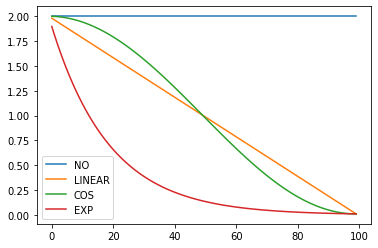

In [ ]:
def plot_annealings():
  #This monkey-patch is there to be able to plot tensors
  torch.Tensor.ndim = property(lambda x: len(x.shape))

  annealings = "NO LINEAR COS EXP".split()
  a = torch.arange(0, 100)
  p = torch.linspace(0.01,1,100)

  fns = [sched_no, sched_lin, sched_cos, sched_exp]
  for fn, t in zip(fns, annealings):
      f = fn(2, 1e-2)
      plt.plot(a, [f(o) for o in p], label=t)
  plt.legend();

plot_annealings()
f = sched_lin(1,2)
f(0.3)

In [ ]:
#export

#----------------------------------------------------
# Combine different schedulers. Use 'scheds[i]' for 'pcts[i]' of the training.
#----------------------------------------------------
def combine_scheds(pcts, scheds):
  # Get the edge percents of each bin from the given percent sizes of each bin. Also
  # add a left-most edge of '0.0'
  bin_edge_pcts = np.cumsum([0.] + pcts)
  def _inner(i_iter, total_iter):
    # Current iteration goes from 0 to total_iter - 1, so bin_idx below will never
    # cross the rightmost 100% bin
    assert(i_iter < total_iter)
    # Get the iteration number of each bin edge based on the total number
    # of iterations
    bin_edge_iters = (bin_edge_pcts * total_iter).astype(int)

    # Index of bin that the current iteration 'i_iter' corresponds to
    bin_idx = np.digitize([i_iter], bin_edge_iters)[0] - 1

    # Calculate the percent position of the current iteration within that bin
    pos_in_bin = i_iter - bin_edge_iters[bin_idx]
    bin_sz = bin_edge_iters[bin_idx + 1] - bin_edge_iters[bin_idx]
    pct_pos_in_bin = pos_in_bin / bin_sz

    sched_fn = scheds[bin_idx]
    return (sched_fn(pct_pos_in_bin))
  return _inner

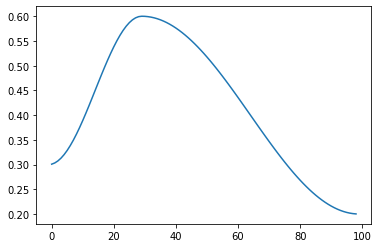

In [ ]:
#----------------------------------------------------
# Combine Scheduler example - Use 30% of the budget to go from 0.3 to 0.6 following 
# a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.
#----------------------------------------------------

sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
a = torch.arange(0, 99)
p = torch.linspace(0.01,0.99, 99)
plt.plot(a, [sched(o) for o in p])

In [ ]:
#export

#----------------------------------------------------
# Callback to store the 'lr' and loss after each batch
# See the OVERVIEW of Variable Learning Rates explanation above for more background
#----------------------------------------------------
class Recorder(Callback):
  def __init__(self):
    self.lrs = []
    self.losses = []

  def end_tr_batch(self, ctx):
    loss = ctx.loss.detach().cpu()
    lrs = [pg['lr'] for pg in ctx.opt.param_groups]

    self.losses.append(loss)
    self.lrs.append(lrs)

    dtr = ctx.dtr
    if (dtr is not None):
      dtr.update_batch({'lr': lrs})

  def plot_lr  (self, pgid=-1): 
    plt.plot(self.lrs)

  def plot_loss(self, skip_last=0): 
    plt.plot(self.losses[:len(self.losses)-skip_last])

class WAIT_Recorder(Callback):
  def __init__(self):
    self.lrs = []
    self.losses = []

  def end_tr_batch(self, ctx):
    for pg in ctx.opt.param_groups:
      self.lrs.append(pg['lr'])
      self.losses.append(ctx.loss.detach().cpu()) 

  def plot_lr  (self, pgid=-1): 
    plt.plot(self.lrs)

  def plot_loss(self, skip_last=0): 
    plt.plot(self.losses[:len(self.losses)-skip_last])
        
  def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        #lrs    = self.lrs[pgid]
        lrs    = self.lrs
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

#----------------------------------------------------
# Callback to vary optimiser hyperparameters for each epoch, based on a scheduling function
# See the OVERVIEW of Variable Learning Rates explanation above for more background
#----------------------------------------------------
class OptimParamCB(Callback):
  def __init__(self, param_name, param_func, total_iter=0):
    self.param_name = param_name
    # Convert to list if it isn't already a list
    self.param_func = param_func if (isinstance(param_func, list)) else [param_func]
    # We are explicitly given the number of iterations in case we have to 
    # train for less than the full number of epochs eg. for lr_find
    self.total_iter = total_iter

  def begin_tr_batch(self, ctx):
    # There are three scenarios:
    #   1. Single param group and single param func
    #   2. Multiple param groups and single param func which is used for all groups
    #   3. Multiple param groups and matching list of multiple param func, each 
    #        function is used for its matching group
    assert (isinstance(self.param_func, list))
    if (self.total_iter > 0):
      # We have been explicitly told to train for less than the full number
      # of epochs
      total_iter = self.total_iter
      assert(self.total_iter <= ctx.num_batches * ctx.num_epochs)
    else:
      total_iter = ctx.num_batches * ctx.num_epochs

    # Current Iteration goes from 0 to total_iter - 1
    assert(ctx.i_tr_iter < total_iter)

    for pg_i, pg in enumerate(ctx.opt.param_groups):
      # Pick the appropriate param func based on the three scenarios above
      if (len(self.param_func) > 1):
        # Scenario #3
        assert(len(ctx.opt.param_groups) == len(self.param_func))
        func = self.param_func[pg_i]
      else:
        # Scenario #1 or #2
        func = self.param_func[0]

      # Use the function to calculate the new hyperparameter value and update it.
      # We provide the current iteration number and the total number of iterations
      # so that the function can determine the new hyperparameter value based on
      # the percent completion of training.
      param_val = func(ctx.i_tr_iter, total_iter)
      # !!!!!!!!!!! momentum and betas for AdamW
      if ((self.param_name == 'momentum') and
          ('betas' in pg.keys())):
        pg['betas'] = (param_val, pg['betas'][1])
      else:
        pg[self.param_name] = param_val

#----------------------------------------------------
# Returns a list of schedules based on Cosine which can be combined to create a
# One-cycle schedule. It goes up from 'start' to a 'high' point and then comes 
# down from 'high' to 'end'
#----------------------------------------------------
def cos_OneCycle(start, high, end):
  return [sched_cos(start, high), sched_cos(high, end)]

#----------------------------------------------------
# Creates the Callbacks necessary for One-Cycle training. Returns a list of
# OptimParamCB callbacks to vary the learning rate and momentum hyperparameters using
# a cosine one-cycle schedule.
#----------------------------------------------------
def create_OneCycleCB(lrs, phases=[0.3, 0.7], mom_start=0.95, mom_mid=0.85, mom_end=0.95):
  start_div, end_div = 25.0, 250000.0
  sched_lr  = [combine_scheds(phases, cos_OneCycle(lr/start_div, lr, lr/end_div)) for lr in lrs]
  sched_mom = combine_scheds(phases, cos_OneCycle(mom_start, mom_mid, mom_end))
  return [OptimParamCB('lr', sched_lr), OptimParamCB('momentum', sched_mom)]

**Test the Recorder and OptimParamCB callbacks**

In [ ]:
# TODO !!!!!!!!!!!! this is temporarily copied here from training_lib, just so that
# we can continue to run the tests below. This problem happened because the Recorder
# and OptimCB and variable rate scheduling were all in training_lib earlier. 
# Get rid of this and replace with run_cnn_mnist

import torch.nn.functional as F
from torch import nn 
from nb_data import MultiDimDataset, get_dls
from nb_util import get_mnist_data
from nb_training import Trainer

def get_linear_model(inp_size, n_classes, lr=0.5, nh=50):
    model = nn.Sequential(nn.Linear(inp_size,nh), nn.ReLU(), nn.Linear(nh, n_classes))
    return model, optim.SGD(model.parameters(), lr=lr)
  
def run_mnist(cbs, num_epochs, repro=False, dtr=None):
  x_train,y_train,x_valid,y_valid = get_mnist_data()
  train_ds,valid_ds = MultiDimDataset(x_train, y_train), MultiDimDataset(x_valid, y_valid)
  train_dl,valid_dl = get_dls(train_ds, valid_ds, bs=512)
  n_classes = y_train.max().item()+1
  loss_func = F.cross_entropy

  if (repro):
    torch.manual_seed(0)
  model, opt = get_linear_model(train_dl.dataset.x.shape[1], n_classes=n_classes, lr=0.5, nh=50)
  loop = Trainer(train_dl, valid_dl, model, opt, loss_func, cbs, dtr)
  loop.fit(num_epochs)
  return(loop)

['epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'time']
['0', '0.783583', '0.785805', '0.315888', '0.908137', '00:00']
['1', '0.299100', '0.912224', '0.237863', '0.931475', '00:00']
['2', '0.235036', '0.932449', '0.213034', '0.939535', '00:00']


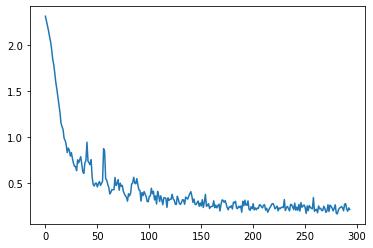

In [ ]:
# Run based on the combined schedule defined earlier
lr_cbs = [Recorder(), MetricsCB({"acc": accuracy}), OptimParamCB("lr", sched)]
loop = run_mnist(lr_cbs, 3, True)

# Plot the loss
loop.cbs[0].plot_loss()

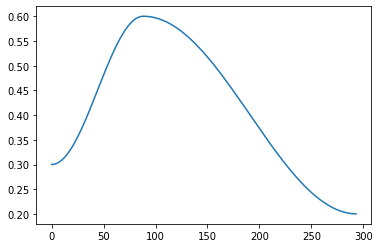

In [ ]:
# Plot the Learning Rate
loop.cbs[0].plot_lr()

**Test the One Cycle Training**

['epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'time']
['0', '0.681738', '0.815787', '0.200953', '0.942668', '00:00']
['1', '0.175514', '0.947574', '0.151158', '0.958275', '00:00']


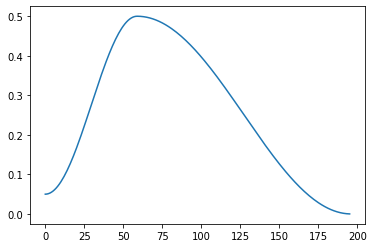

In [ ]:
onecycle_cbs = [Recorder(), MetricsCB({"acc": accuracy})] + create_OneCycleCB(lrs=[0.5])
loop = run_mnist(onecycle_cbs, 2, True)

# Plot the Learning Rate
loop.cbs[0].plot_lr()

#### LR Range Find Callback

In [ ]:
#export

class LRRangeFind(Callback):
  def __init__(self, num_iter):
    self.num_iter = num_iter
    self.best_loss = 0

  def end_tr_batch(self, ctx):
    # !!!!!!! Also should stop training if loss shoots up out of control

    if ((ctx.i_tr_iter == 0) or (ctx.loss < self.best_loss)):
      self.best_loss = ctx.loss.detach()

    # +1 because i_tr_iter starts from 0
    if ((ctx.i_tr_iter + 1 >= self.num_iter) or
        (ctx.loss > self.best_loss * 4)):
      raise CancelFitException()

### Use different custom Optimisers - SGD, Weight Decay, Momentum, Adam, LAMB

In [ ]:
#export

# In PyTorch, the base optimizer in torch.optim contains a dictionary that stores the model parameters in 
# different parameter groups along with the hyperparameters for each group. Each parameter group can have 
# different hyper-parameters eg. different learning rates/momentum/weight decay. This is how we can do 
# discriminative learning rates).
#
# An optimiser contains a method step() that updates our parameters with the gradients and 
# a method zero_grad to detach and zero the gradients of all our parameters
#
# The Pytorch optimiser takes in arguments in two flavours.
#   i) A list of parameters, followed by hyperparameters. This means a single parameter group
#      consisting of all parameters.
#   ii) A list of dictionaries, followed by hyperparameters. Each dictionary describes one
#       parameter group. It has a key for 'params' and the value is a list of parameters. It
#       can also have keys for hyperparameters which apply only to that parameter group
#
# An example of the 2nd flavour is:
#  opt = opt_func([
#     {'params': params[:3], 'lr': 0.5, 'weight_decay': 0.1},
#     {'params': params[3:], 'momentum': 0.88}
#  ], lr=0.6)
#
# In this example, the hyperparameter 'lr=0.6' applies to all the parameter groups, unless
# a particular group overrides them. For example, the first group has overridden it with 'lr=0.5'

#----------------------------------------------------
# Create Pytorch-equivalent optimiser from scratch. We add one more argument which is a
# list of stepper functions, which have to be passed in using partials. Each stepper function
# loops over all the parameters to execute the step. This allows us to plug in different step 
# algorithms
#
# Hyperparameters are specified at three levels:
#   1) Default hyperparameters - these are 'built-in' and defined within the stepper function
#   2) Common hyperparameters - these are common to all parameter groups
#   3) Group-specific hyperparameters - these are specific to one parameter group
# #3 overrides #2, which overrides #1. The user can pass in #2 and #3. 
#
# Params - a list of parameters, or a list of dictionaries for each parameter group
# Steppers - a list of stepper functions
# Hypers_all - a dictionary of hyperparameters which are common to all parameter groups
#----------------------------------------------------
class Optimizer():
    def __init__(self, params, steppers, **hypers_common):
        # Params is a generator, so materialise it
        self.param_groups = list(params)

        # Get default values for any hyperparameters defined by each stepper function
        hypers_default = self._get_hypers_default(steppers)
        
        # Merge those values into the passed in hyperparameters. The passed in hyperparameters
        # override the default ones. These are now the common hyperparameters that apply
        # to all parameter groups
        hypers_all = {**hypers_default, **hypers_common}

        # Check which flavour of params we have been given:
        #   a list of parameters representing a single parameter group, or 
        #   a list of dictionaries, representing multiple parameter groups
        # Convert both into a common format viz. a list of dictionaries, with one
        # dictionary per parameter group
        if not isinstance(self.param_groups[0], dict):
          # This is a single parameter group. Convert it to a list with a single 
          # dictionary for a single group with all hyperparameters 
          self.param_groups = [{'params': self.param_groups, **hypers_all}]
        else:
          # These are multiple parameter groups. Merge the common hyperparameters
          # into every dictionary. The group-specific hyperparameters override the
          # common ones
          self.param_groups = [{**hypers_all, **pg} for pg in self.param_groups]

        # List of stepper functions
        self.steppers = listify(steppers)

        self._print_opt()

    # ----------------------------
    # Get a dictionary of all default hyperparameters from all stepper functions
    # ----------------------------
    def _get_hypers_default(self, steppers):
      hypers_default = dict()

      # Go through all stepper functions and check if it has a '_defaults' attribute
      for stepper in steppers:
        defaults = getattr(stepper, '_defaults', {})
        hypers_default.update(defaults)
      return (hypers_default)

    # ----------------------------
    # For debugging. Print all the parameter groups with their hyperparameters
    # ----------------------------
    def _print_opt(self):
      for pg in self.param_groups:
        hyper = {k:v for k,v in pg.items() if k != 'params'}
        print (len(pg['params']), hyper)
    
    # ----------------------------
    # Zero out all parameters for all parameter groups
    # This function is part of Pytorch's Optimiser 'interface'
    # ----------------------------
    def zero_grad(self):
      for pg in self.param_groups:
        for p in pg['params']:
          if (p.grad is not None):
            p.grad.detach_()
            p.grad.zero_()

    # ----------------------------
    # Implement a gradient update step
    # This function is part of Pytorch's Optimiser 'interface'
    # ----------------------------
    def step(self):
      # Go through all parameter groups
      for pg in self.param_groups:
        # Get the hyperparameters for each group. 'pg' is a dictionary
        hyper = {k:v for k,v in pg.items() if k != 'params'}

        # Go through the list of parameters 'p' for this group.
        for p in pg['params']:
          if (p.grad is not None):
            # Apply each stepper function to the parameter in a pipeline
            compose(p, self.steppers, **hyper)

### SGD

In [ ]:
#export

#----------------------------------------------------
# Vanilla Stochastic Gradient Descent optimiser. 
# This is equivalent to Pytorch's built-in optim.SGD optimiser
#----------------------------------------------------
def sgd_step(p, lr, **kwargs):
  p.data = p.data - lr * p.grad.data

  # Alternate syntax - this first multiplies 'lr' with the gradients and then adds it in place
  #p.data.add_(-lr, p.grad.data)

  return p
sgd_step._defaults = dict(lr=0.2)

In [ ]:
# Use our Stochastic Gradient Descent Optimiser with a single parameter group. It should 
# produce identical results to Pytorch's built-in SGD optimiser below
lr_cbs = [MetricsCB({"acc": accuracy})]
opt_func = partial(Optimizer, steppers=[sgd_step])
run_cnn_mnist(1, CNNArch(), opt_func=opt_func, cbs=lr_cbs, repro=True)

# Use our Optimiser with multiple parameter groups. The parameter groups are defined as a tuple
# of (splitter function, group specific hyperparameters, common hyperparameters)
# Group hyperparameters eg. [{hyperparameters for first group}, {hyperparameters for second group}]
# Common hyperparameters eg. {common hyperparameters}
opt_group = (partial(split_sequence, param_idxs=[3]), [{'lr': 0.5, 'weight_decay': 0.1}, {'momentum': 0.88}], {'lr': 0.6})
run_cnn_mnist(1, CNNArch(), opt_func=opt_func, opt_groups=opt_group, cbs=lr_cbs, repro=True)

# Use Pytorch's built-in SGD Optimiser
run_cnn_mnist(1, CNNArch(), cbs=lr_cbs, repro=True)

### Test with Parameter Scheduler and Recorder

In [ ]:
#----------------------------------------------------
# Plot loss using Built-in Optimiser and a variable learning rate scheduler
#----------------------------------------------------

sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
lr_cbs = [CudaCB(device = torch.device('cuda',0)), Recorder(), MetricsCB({"acc": accuracy}), OptimParamCB("lr", sched)]
loop = run_cnn_mnist(1, CNNArch(), cbs=lr_cbs, repro=True)
loop.cbs[1].plot_loss()

In [ ]:
#----------------------------------------------------
# Plot loss using our Optimiser and make sure it is similar to the built-in
#----------------------------------------------------
opt_func = partial(Optimizer, steppers=[sgd_step])
lr_cbs = [CudaCB(device = torch.device('cuda',0)), Recorder(), MetricsCB({"acc": accuracy}), OptimParamCB("lr", sched)]
loop = run_cnn_mnist(1, CNNArch(), opt_func=opt_func, cbs=lr_cbs, repro=True)
loop.cbs[1].plot_loss()

In [ ]:
#----------------------------------------------------
# Plot learning rate
#----------------------------------------------------
loop.cbs[1].plot_lr()

### Weight Decay and L2 Regularisation

In [ ]:
#export

#----------------------------------------------------
# Weight Decay optimiser
# new_weight = weight - lr * weight.grad - lr * wd * weight
# New Weight = Weight - Regular SGD - Weight Decay
#----------------------------------------------------
def weight_decay_step(p, lr, weight_decay, **kwargs):
    p.data = p.data * (1 - lr*weight_decay)
    
    #p.data.mul_(1 - lr*weight_decay)
    return p
weight_decay_step._defaults = dict(weight_decay=0.)

#----------------------------------------------------
# L2 Regularisation optimiser (very similar to Weight Decay)
# weight.grad += wd * weight
#----------------------------------------------------
def l2_reg_step(p, lr, weight_decay, **kwargs):
  p.grad.data = p.grad.data + weight_decay * p.data
  #p.grad.data.add_(weight_decay, p.data)
  return p
l2_reg_step._defaults = dict(weight_decay=0.)

# Define an optimisation function using SGD and Weight Decay
sgd_opt_func = partial(Optimizer, steppers=[weight_decay_step, sgd_step])

In [ ]:
# Test an Optimiser with Weight Decay + SGD steppers
opt_func = sgd_opt_func
# No parameter groups, but provide common hyperparameters
opt_group = (None, [{}], {'lr': 0.4, 'weight_decay': 1e-4})
run_cnn_mnist(1, CNNArch(), opt_func=opt_func, opt_groups=opt_group, cbs=lr_cbs, repro=True)

### Momentum Optimiser

In [ ]:
#export

#----------------------------------------------------
# Momentum optimiser
#
# Calculate momentum state (ie. Moving Average of Momentum) for the gradient of each parameter and save
# that state with the parameter tensor
#----------------------------------------------------
def momentum_step(p, lr, momentum, **kwargs):
  # Initialise the moving average to 0. Save the moving average as an attribute of the
  # parameter tensor
  if (getattr(p, 'mov_avg', None)) is None:
    p.mov_avg = torch.zeros_like(p.grad.data)
  
  # Calculate moving average of the gradient using momentum 'beta'
  p.mov_avg = p.mov_avg * momentum + p.grad.data
  #print(p.data.shape, p.data.mean(), p.mov_avg.mean())

  # Update the parameter using the moving average of the gradient, rather than the gradient itself
  p.data = p.data - lr * p.mov_avg
  return p
momentum_step._defaults = dict(momentum=0.9)

In [ ]:

opt_func = partial(Optimizer, steppers=[momentum_step, weight_decay_step], weight_decay=0.01)
run_cnn_mnist(1, CNNArch(), lr=0.3, opt_func=opt_func, cbs=lr_cbs, repro=True)

#opt_func = partial(Optimizer, steppers=[momentum_step, weight_decay_step], weight_decay=1e-4)
#run_cnn_mnist(1, CNNArch(), opt_func=opt_func, cbs=lr_cbs, repro=True)

### Adam optimiser

In [ ]:
#export

#----------------------------------------------------
# Adam optimiser
#
# Calculate Momentum (ie. Exponential Moving Average of Gradient) and RMSProp (ie. Exponential Moving Average of Gradient Squared).
# Use de-biasing to adjust the calculated moving averages
# Save that state with the parameter tensor and then update the parameters
#----------------------------------------------------
def adam_step(p, lr, momentum, sqr_momentum, eps, **kwargs):
  # Initialise all the exponential moving averages to 0
  if (getattr(p, 'exp_avg', None)) is None:
    p.exp_avg = torch.zeros_like(p.grad.data)
    p.exp_avg_sqr = torch.zeros_like(p.grad.data)
    p.step_count = 0
  
  # Calculate the exponential moving averages using two different 'beta' hyperparameters
  # Rename internal variables from momentum to beta for the calculations
  avg_beta, avg_sqr_beta = momentum, sqr_momentum
  p.exp_avg = p.exp_avg * avg_beta + ((1 - avg_beta) * p.grad.data)
  p.exp_avg_sqr = p.exp_avg_sqr * avg_sqr_beta + ((1 - avg_sqr_beta) * p.grad.data * p.grad.data)

  # Adjust both exponential moving averages using de-biasing
  p.step_count += 1
  debias_avg = 1 - avg_beta**p.step_count
  debias_avg_sqr = 1 - avg_sqr_beta**p.step_count

  # Update the parameters by combining both the debiased moving averages as per the Adam formula
  p.data = p.data - lr * (p.exp_avg / debias_avg) / ((p.exp_avg_sqr/debias_avg_sqr).sqrt() + eps)

  return p
adam_step._defaults = dict(momentum=0.9, sqr_momentum=0.99, eps=1e-5)

# Define an optimisation function using Adam
adam_opt_func = partial(Optimizer, steppers=[adam_step, weight_decay_step])

In [ ]:
# Test Adam with Weight Decay with no parameter groups
opt_func = partial(Optimizer, steppers=[adam_step, weight_decay_step], weight_decay=0.01)
run_cnn_mnist(1, CNNArch(), lr=0.001, opt_func=opt_func, cbs=lr_cbs, repro=True)

### Lamb optimiser

In [ ]:
#export

#----------------------------------------------------
# Lamb optimiser
# Is an enhancement of Adam as the base algorithm
#----------------------------------------------------
def lamb_step(p, lr, momentum, sqr_momentum, eps, weight_decay, **kwargs):
  # Initialise all the exponential moving averages to 0
  if (getattr(p, 'exp_avg', None)) is None:
    p.exp_avg = torch.zeros_like(p.grad.data)
    p.exp_avg_sqr = torch.zeros_like(p.grad.data)
    p.step_count = 0
  
  # Calculate the exponential moving averages using two different 'beta' hyperparameters
  # Rename internal variables from momentum to beta for the calculations
  avg_beta, avg_sqr_beta = momentum, sqr_momentum
  p.exp_avg = p.exp_avg * avg_beta + ((1 - avg_beta) * p.grad.data)
  p.exp_avg_sqr = p.exp_avg_sqr * avg_sqr_beta + ((1 - avg_sqr_beta) * p.grad.data * p.grad.data)

  # Adjust both exponential moving averages using de-biasing
  p.step_count += 1
  debias_avg = 1 - avg_beta**p.step_count
  debias_avg_sqr = 1 - avg_sqr_beta**p.step_count

  # Calculate the ratios as per the Lamb formula
  r1 = p.data.pow(2).mean().sqrt()
  step = ((p.exp_avg / debias_avg) / ((p.exp_avg_sqr/debias_avg_sqr).sqrt() + eps)) + weight_decay * p.data
  r2 = step.pow(2).mean().sqrt()

  # Update the parameters by adjusting the learning rate as per the ratio
  p.data = p.data - (lr * min(r1/r2, 10)) * step

  return p
lamb_step._defaults = dict(momentum=0.9, sqr_momentum=0.99, eps=1e-6, weight_decay=0.01)

In [ ]:
# Test Lamb with no parameter groups
opt_func = partial(Optimizer, steppers=[lamb_step])
run_cnn_mnist(1, CNNArch(), lr=0.003, opt_func=opt_func, cbs=lr_cbs, repro=True)

### Hyper Parameter Interface

In [ ]:
#export

# -------------------
# This should also include all the Variable LR logic from training_lib such as
# the schedulers, Recorder, OptimCB and OneCycle convenience 
# It also includes the get_optimiser from optimiser_lib
# This will go into optimser_lib
# HyperParams have three arguments:
#   1. Which module-layer groups (the parameter groups can be easily derived from that)
#   2. Which hyperparameters to be used and what their (initial) values are
#   3. How will those hyperparameters be varied
#
# Most commonly,
#   2. We mostly use LR
#   3. We vary LR and (maybe Momentum) using One Cycle
#
# HyperParams are largely managed by the Optimiser and OptimCB.
# #1 and #2 are managed by the Optimiser class and #3 by the OptimCB.
#     NB: The Schedulers and Recorders are simply supporting functions for the OptimCB
# -------------------
class HyperParams():
  # !!!! NB: Cleaner API would be below, where 'hp' is other hyper params like weight decay
  # !!!!  set(cls, module_groups, split_lr, hp=None, lr_sched=None, opt_func=adam_opt_func)

  @classmethod
  def set(cls, model, module_groups, split_lr, split=False, lr_sched=None, opt_func=adam_opt_func, **kwargs):
    # split_lr is a list:
    #   1. a single-element list [0.01] - same LR for all groups. 
    #        If 'Split' is False, there is only one group. 
    #        If 'Split' is True, there are multiple groups.
    #   2. a multi-element list [0.01, 0.03, 0.05] - discriminative LR for different groups. 
    #        'Split' cannot be False
    assert(isinstance(split_lr, list))
    assert(len(split_lr) > 0)
    assert(not ((split == False) and (len(split_lr) > 1)))

    hyper_cbs = cls.variable_lr(split_lr, lr_sched, **kwargs)
    opt = cls.discriminative_lr(model, module_groups, opt_func, split_lr, split)

    return (opt, hyper_cbs)

  # ----------------------------
  # Initialise the Optimiser with parameter groups and hyperparameters for
  # each group
  # ----------------------------
  @staticmethod
  def discriminative_lr(model, module_groups, opt_func, split_lr, split):

    lr = split_lr[0]
    if (split):
      # List of list of parameters by group
      splitter_func = lambda m, mgs: [list(o.parameters()) for o in mgs]
      splitter_func = partial (splitter_func, mgs=module_groups)

      if (len(split_lr) == 1):
        hypers_group = [{}] * len(module_groups)
        opt_groups=(splitter_func, hypers_group, {'lr': lr})

      elif (len(split_lr) > 1):
        hypers_group = [{'lr': lr_g} for lr_g in split_lr]
        opt_groups=(splitter_func, hypers_group, {})

    else:
      opt_groups = None

    opt = get_optimiser(model, lr, opt_func, opt_groups)
    return opt

  # ----------------------------
  # Create the callbacks required for Variable LRs
  #
  # NB: Right now it only supports this using One Cycle scheduling. So this function
  # doesn't need to be called if 'one_cycle' is False. However we will extend it by
  # adding other variable scheduling methods, so the caller simply calls it and gets
  # back the list of callbacks without checking flags on the caller's side.
  # !!!!!!!!!!! new implementation - correct default values of arguments
  # ----------------------------
  @staticmethod
  def variable_lr(split_lr, lr_sched, **kwargs):
    if (lr_sched == 'one_cycle'):
      one_cycle_callbs = create_OneCycleCB(split_lr, phases=[0.3, 0.7], mom_start=0.95, mom_mid=0.85, mom_end=0.95)
      return one_cycle_callbs
    
    elif (lr_sched == 'lrf'):
      start_lr, end_lr, num_iter = kwargs['start_lr'], kwargs['end_lr'], kwargs['num_iter']
      sched_lr = [combine_scheds([1.0], [sched_exp(start_lr, end_lr)])]
      exp_callbs = [OptimParamCB('lr', sched_lr, total_iter=num_iter)]
      return exp_callbs

    else:
      return []


### Export

In [ ]:
!wget https://raw.githubusercontent.com/ketanhdoshi/ml/master/lib/nb_export.py

In [ ]:
from nb_export import notebook2scriptSingle
notebook2scriptSingle(gn_path + '/lib/optimiser_lib.ipynb', gn_path + '/exp')

Converted gdrive/My Drive/Colab Notebooks/lib/optimiser_lib.ipynb to gdrive/My Drive/Colab Notebooks/exp/nb_optimiser.py
